# Entrega 2 - Título

### Grupo 12:
     - Santiago Pais  C.I. 5.136.231-0
     - Tiagui Samurio C.I. 5.240.686-6
     - Agustin Gamio C.I. 5.166.722-5

## 1. Objetivo

El objetivo de esta tarea es construir un jugador/clasificador/... utilizando... .

El éxito del aprendizaje se mide a través de...


## 2. Evaluación de Herramientas

**Preprocesamiento**

* Valores faltantes: No aplica
* Atributos categóricos: No aplica, Naive Bayes trabaja con atributos categóricos
* Atributos numéricos: división en rangos de la misma manera que para construír un histograma
* Estandarización de atributos: como se utiliza la probabilidad de ocurrencia de un valor para un atributo y ésta ya está normalizada por definición. No aplica
* Estratificación: Puede ser de utilidad dado que la clase objetivo está desbalanceada

**División del conjunto de datos**

*Métodos de filtrado*
* Básica: sirve para estudiar la utilidad de variables numéricas
* $χ^2$: sirve para estudiar la utilidad de las variables binarias y categóricas.
* Ganancia de información: ya fue utilizado en el laboratorio anterior.

*Métodos Wrappers*: No aplica.

*Métodos Embedded*: No aplica.

**Entrenamiento**

* Validación cruzada: sirve para una mejor utilización del corpus de entrenamiento y permite disminuír la varianza de los resultados (por tanto es más confiable).

**Evaluación**

Se utizarán los siguientes métodos:
* Accuracy
* Evaluación de hipótesis
* Precisión y recuperación
* Medida F
* Curvas Precisión - Recall
* Matriz de confusión



In [ ]:
############## CARGA DE DATOS ######################

import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2

DATASET_FILE = "./lab1_dataset.csv"

In [ ]:
dataset = pd.read_csv(DATASET_FILE, sep=",")
dataset = dataset.drop('pidnum', axis=1)
print(
    f"{dataset.shape[0]} records read from {DATASET_FILE}\n{dataset.shape[1]} attributes found"
)


2139 records read from ./lab1_dataset.csv
24 attributes found


###Preprocesamiento

De datos numéricos:
* Se utilizará el filtrado básico para atributos numéricos, descartando aquellos que presenten una baja varianza.

In [ ]:
#Valores numericos:
numeric_values = ["time", "age", "wtkg", "karnof", "preanti", "cd40", "cd420", "cd80", "cd820"] #strat es categorico pero tiene un orden claro. (P.ej: caso max range = 2, splitter lo partiria en (No uso el tratamiento, uso el tratamiento) o bien (Uso el tratamiento por <= 52 semanas, uso el tratamiento > 52 semanas))
categorical_values = ["trt", "strat"]
binary_values = ["cid","hemo","homo","drugs","oprior","z30","zprior","gender","str2","symptom","treat","offtrt"]
dataset.head(10)

statistics = {}
for attribute in numeric_values:
    mean_value = dataset[attribute].mean()
    std_value = dataset[attribute].std()
    statistics[attribute] = {'mean': mean_value, 'std': std_value}
    if std_value < 100:
      dataset.drop(attribute,axis=1)
      print(f"El atributo {attribute} fue eliminado pues su desviación estandar = {std_value} era muy baja")


El atributo age fue eliminado pues su desviación estandar = 8.70902623400872 era muy baja
El atributo wtkg fue eliminado pues su desviación estandar = 13.263164003518359 era muy baja
El atributo karnof fue eliminado pues su desviación estandar = 5.900984556229983 era muy baja


De datos categóricos y binarios:
* se utilizará el método $χ^2$ para obtener los atributos más correlacionados con la clase objetivo.

In [ ]:
y = dataset['cid']

# Selección de características
selector = SelectKBest(score_func=chi2, k=14)
selected_features = selector.fit_transform(dataset, y)

# Convertir el resultado de nuevo en un DataFrame
selected_columns = dataset.columns[selector.get_support()]
dataset = pd.DataFrame(selected_features, columns=selected_columns)

dataset.head(10)
unique_values = {col: dataset[col].dropna().unique().tolist() for col in dataset.columns}
unique_counts = {col: len(values) for col, values in unique_values.items()}
print(unique_counts)

{'cid': 2, 'time': 713, 'trt': 4, 'age': 59, 'z30': 2, 'preanti': 813, 'str2': 2, 'strat': 3, 'symptom': 2, 'offtrt': 2, 'cd40': 484, 'cd420': 570, 'cd80': 1090, 'cd820': 1050}


In [ ]:
train, test = model_selection.train_test_split(dataset, test_size=0.2, random_state=42)

In [ ]:
def m_estimator(m,p,nc,n):
    #return (nc + (m * p)) / (n + m)
    return  np.log((nc + (m * p)) / (n + m))

In [ ]:
def nb(ds,instance):
    m = 1000 #m_estimator
    given_1 = {} #diccionario que tiene la cantidad de instancias de cada atributo y un valor de este atriburo dado la columna cid == 0
    given_0 = {} #diccionario que tiene la cantidad de instancias de cada atributo y un valor de este atriburo dado la columna cid == 0
    """
    given_0 = {'trt': {1: 342, 3: 340, 2: 327, 0: 282},
               'hemo': {0: 1183, 1: 108},
               'homo': {1: 836, 0: 455},
               ...
               }
    """
    total_instances = ds.shape[0] #cantidad de instancias de train
    total_0 = ds[ds['cid'] == 0].shape[0] #cantidad de instancia de train donde cid == 0
    total_1 = ds[ds['cid'] == 1].shape[0] #cantidad de instancia de train donde cid == 0
    prob_0 = total_0 / total_instances
    prob_1 = total_1 / total_instances
    ds_filtrado_0  = ds[(ds['cid'] == 0)]
    ds_filtrado_1 = ds[(ds['cid'] == 1)]
    for col in ds.columns:  #aca lleno los diccionarios given_1 y given_0.
        if col == 'cid':
            continue
        # Obtengo la cantidad de ocurrencias de todos los valores en la columna col, dado cid == 0.
        value_counts = ds_filtrado_0[col].value_counts().to_dict()
        # Aseguro que todos los valores esten incluidos
        for value in unique_values[col]: #en caso de que en el conj. de datos train no tenga todos los valores posibles, agrego el valor con 0, ya que tiene 0 ocurrencais
            if value not in value_counts:
                value_counts[value] = 0
        # Store the value counts in the dictionary
        given_0[col] = value_counts
        # Obtengo la cantidad de ocurrencias de todos los valores en la columna col, dado cid == 0.
        value_counts = ds_filtrado_1[col].value_counts().to_dict()
        for value in unique_values[col]:
            if value not in value_counts:
                value_counts[value] = 0
        # Store the value counts in the dictionary
        given_1[col] = value_counts
    prob_given_0 = 0
    prob_given_1 = 0
    for col in ds.columns:
        if col == 'cid':
            continue
        #prob_given_0 = prob_given_0 * (m_estimator(m,(1/unique_counts[col]),given_0[col][instance[col]],total_0))
        #prob_given_1 = prob_given_1 * (m_estimator(m,1/unique_counts[col],given_1[col][instance[col]],total_1))
        prob_given_0 = prob_given_0 + (m_estimator(m,(1/unique_counts[col]),given_0[col][instance[col]],total_0))
        prob_given_1 = prob_given_1 + (m_estimator(m,1/unique_counts[col],given_1[col][instance[col]],total_1))
    prob_given_0 = prob_given_0 + np.log(prob_0)
    prob_given_1 = prob_given_1 + np.log(prob_1)
    #print (given_0)
    if prob_given_0 >= prob_given_1:
        return 0
    else:
        return 1


In [ ]:
#Funcion usada para evaluar el modelo generalizado.
resultados = {
    'Accuaracy': [],
    'Precisión': [],
    'Recall': [],
    'F1-Score': []
}

def evaluar(train,test):
    true_positives = {} #Número de instancias correctamente predichas para una clase específica.
    false_positives = {} #Número de instancias predichas como una clase específica pero que pertenecen a otra clase.
    false_negatives = {} #Número de instancias de una clase específica que no fueron predichas correctamente.
    true_negatives = {} #Número de instancias correctamente identificadas como no pertenecientes a una clase específica.
    clases = test['cid'].unique()
    # Initialize dictionaries for each class
    for clase in clases:
        true_positives[clase] = 0   #true_positives[0] tomo como positivo 0 y negativo 1 y asi.
        false_positives[clase] = 0
        false_negatives[clase] = 0
        true_negatives[clase] = 0

    # Evaluate the model on the test data
    for i, instancia in test.iterrows():
        etiqueta_real = instancia['cid']
        prediccion = nb(train,instancia)

        if prediccion == etiqueta_real:
            true_positives[etiqueta_real] += 1
            for clase in clases:
                if clase != etiqueta_real:
                    true_negatives[clase] += 1
        else:
            false_positives[prediccion] += 1
            false_negatives[etiqueta_real] += 1
            for clase in clases:
                if clase != etiqueta_real and clase != prediccion:
                    true_negatives[clase] += 1

    # Calculate precision, recall, and F1-score for each class
    precision = {} #Proporción de instancias correctamente predichas para una clase específica entre todas las instancias predichas como esa clase.
    recall = {} #Proporción de instancias de una clase específica que fueron correctamente identificadas.
    f1_score = {} # Media armónica de la precisión y el recall, balanceando ambas métricas.

    for clase in clases:
        precision[clase] = true_positives[clase] / (true_positives[clase] + false_positives[clase]) if (true_positives[clase] + false_positives[clase]) > 0 else 0
        recall[clase] = true_positives[clase] / (true_positives[clase] + false_negatives[clase]) if (true_positives[clase] + false_negatives[clase]) > 0 else 0
        f1_score[clase] = 2 * (precision[clase] * recall[clase]) / (precision[clase] + recall[clase]) if (precision[clase] + recall[clase]) > 0 else 0

    # Calculate overall accuracy
    aciertos = sum(true_positives.values())
    precision_general = aciertos / len(test) #Proporción de instancias correctamente predichas entre todas las instancias.

    resultados['Accuaracy'].append(precision_general)
    resultados['Precisión'].append(precision)
    resultados['Recall'].append(recall)
    resultados['F1-Score'].append(f1_score)

    print(resultados)


    return precision_general, precision, recall, f1_score

In [ ]:
evaluar(train,test)

{'Accuaracy': [0.7429906542056075], 'Precisión': [{0.0: 0.7972602739726027, 1.0: 0.42857142857142855}], 'Recall': [{0.0: 0.8899082568807339, 1.0: 0.26732673267326734}], 'F1-Score': [{0.0: 0.8410404624277457, 1.0: 0.3292682926829268}]}


(0.7429906542056075,
 {0.0: 0.7972602739726027, 1.0: 0.42857142857142855},
 {0.0: 0.8899082568807339, 1.0: 0.26732673267326734},
 {0.0: 0.8410404624277457, 1.0: 0.3292682926829268})

In [ ]:
##### DE CHATGPT FALTA VERIFICAR
# Entrenamiento y evaluación del modelo para cada valor de m
for m in m_values:
    print(f'\nEvaluando para m = {m}')
    nb = NaiveBayesWithM(m)
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:")
    print(cm)

    # Curva precision-recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, precision, label=f'm = {m}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # Reporte de clasificación
    print(classification_report(y_test, y_pred))

plt.title('Curva Precision-Recall para diferentes valores de m')
plt.legend()
plt.show()

# Validación cruzada (ejemplo de 5 folds)
scores = cross_val_score(nb.model, X_new, y, cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Promedio de cross-validation: {np.mean(scores)}')

## Por ejemplo, para un jugador:
    
## 2.1 Juego
- Decisiones sobre las reglas de juego, simplificaciones, etc.


## 2.2 Tablero
- Representación del tablero, justificación de los atributos utilizados
- ¿Se prueban con varios subconjuntos de atributos distintos?; en caso afirmativo, ¿por qué?
- Ejemplos de algunos tableros y el valor de los atributos elegidos.


## 2.4 Algoritmo
- ¿cómo se representa a la función de valoración? ¿qué valores toma?
- ¿cómo se ajusta?
- ¿cuándo se ajusta? ¿cada turno? ¿final del partido? ¿cada N partidos?
- ¿con qué valores de $\alpha$ se prueba? ¿por qué?
- ¿Se utiliza enfriamiento? ¿cómo?

Tal vez precisen agregar algo de pseudocódigo o código para ejemplificar:

```python
    def f(x):
        return x
```

## 2.4 Contrarios
- ¿qué jugadores contrarios se implementan? describir cada uno.
- por ejemplo, deben quedar respondidas las siguientes preguntas: ¿cómo se eligen las jugadas del jugador al azar? ¿cada cuánto se actualizan los pesos de "mi versión previa"?

## Por ejemplo, para un clasificador:
    

## 2.1 Preprocesamiento de datos
- Decisiones sobre tratamiento de datos numéricos, faltantes, etc. antes de la aplicación de el algoritmo
- Selección/generación de atributos


## 2.2 Algoritmo
Extensiones del algoritmo original necesarias para la resolución del problema: tratamiento de atributos faltantes, numéricos, etc. (si es el propio algoritmo el que lo maneja), implementaciones adicionales necesarias para manejar ensambles de clasificadores, etc.


## 2.3 Evaluación
- Qué conjunto de métricas se utilizan para la evaluación de la solución y su definición
- Sobre qué conjunto(s) se realiza el entrenamiento, ajuste de la solución, evaluación, etc. Explicar cómo se construyen estos conjuntos.

## 3. Experimentación

- Presentar los distintos experimentos que se realizan y los resultados que se obtienen.

- La información de los resultados se presenta en tablas y en gráficos, de acuerdo a su naturaleza. Por ejemplo:

_En la gráfica 1, se observa el error cuadrático total del conjunto de entrenamiento a medida que pasan los juegos para el oponente X_

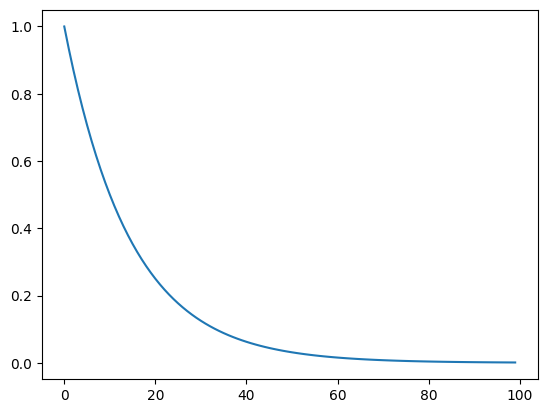

In [ ]:
import matplotlib.pyplot
matplotlib.pyplot.plot(range(0,100), [2**-(x/10) for x in range(0,100)])


- Debe existir alguna instancia donde se compile la información relevante de los experimentos de forma de poder comparar fácilmente los distintos experimentos. Por ejemplo:

_En la tabla 1, se presentan los distintos resultados contra el jugador aleatorio, para los distintos valores de $\alpha$ elegidos. El mejor resultado se obtiene para $\alpha=0.05$, lo que prueba que la estrategia..._

<table>
  <tr>
    <th>$\alpha$</th>
    <th>...</th>
    <th>Turnos</th>
    <th>Error</th>
  </tr>
  <tr>
    <td>0.001</td>
    <td>...</td>
    <td>100</td>
    <td>0.991</td>
  </tr>    
  <tr>
    <td>0.005</td>
    <td>...</td>
    <td>100</td>
    <td>0.987</td>
  </tr>
  <tr style="font-weight:bold">
    <td>0.05</td>
    <td>...</td>
    <td>100</td>
    <td>0.329</td>
  </tr>
  <tr>
    <td>0.5</td>
    <td>...</td>
    <td>100</td>
    <td>0.564</td>
  </tr>    
    <caption>Tabla 1 - Entrenamiento del jugador X para distintos valores de $\alpha$</caption>
</table>


## 4. Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo:
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?